# Glassdoor HR Review Detector

# 1. Theory

- The kinds of words that genuine employees use in glassdoor review is different from the one used by HR.
- So my theory is that I can use AI to distinguist between these two kind of reviews.
- This will be achived using embeddings. An embedding is a coversion of natural language to vectors. Vectors of similar words are close to each other. My theory is that one or more regions of of the vector space are more of the human resources kind while other regions are more of the genuine employee kinds.
- My goal is to train a neural network to identify regions in the vector space that are "hr"-ish vs. regions that are "genuine"-ish. Based on this, given a review text, the network will be able to predict if the review was written by HR or not.


- Training data consists of pros, cons, overall review, sounds like hr
- pros, cons represented as vector embeddings using openai api

> **NOTE**: How is the `sounds_like_hr` field set in the training data? The answer is that I set it based on my gut instinct! **Please do not take this project seriously**, it's just an excuse to try out machine learning algorithms. For context: I used Glassdoor in the past and suspected some reviews were written by HR; either because they would say there are no cons or they would pander to the company like 'you have to work late, but it's worth it'. I thought it would be a fun project to build an AI that could detect this based on my instinct rather than emperical data.

## 1.1 Quick Experiment

A quick experiment to see if my theory has some merit is the following:
1. Take a subset of training data
1. Divide training data into training set, test set.
1. Convert  reviews in the training set to embeddings
1. Store the embeddings in an in-memory vector store.
1. Query the vector store with genuine review (from the test set) ... should return other reviews that sound genuine
1. Query the vector store with hr review (from the test set) ... should return other reviews that sound hr.



In [4]:
import csv
import tempfile
from utils.utils import load_csv_as_dictionary, array_of_dictionaries_to_csv_string
from sklearn.model_selection import train_test_split
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_chroma import Chroma
import pandas as pd

# 1. load csv as array of objects 
data = load_csv_as_dictionary(csv_filename='training-data/glassdoor-reviews-main.csv')
for item in data:
    item['sounds_like_hr'] = int(item['sounds_like_hr'])

# 2. use scikit learn to split into training and test set?
training_set, test_set = train_test_split(data, test_size=0.40, random_state=1)

# 3. Format training set into csv

training_set_csv = array_of_dictionaries_to_csv_string(training_set)

    
# 4. embed training set openai API and store in in-memory vector db
with tempfile.NamedTemporaryFile(delete=False, mode="w+") as temp_file:
    temp_file.write(training_set_csv)
    temp_file_path = temp_file.name

loader = CSVLoader(file_path=temp_file_path)
documents = loader.load()
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [5]:
review_genuity_dict = {item["id"]: item["sounds_like_hr"] for item in data}

total_genuine_reviews_in_test_set = 0
# Incremented when a genuine review in the test set matches a genuine review in the training set.
correctly_matched_genuine_revews = 0

total_hr_reviews_in_test_set = 0
# Incremented when a hr review in the test set matches a hr review in the training set.
correctly_matched_hr_revews = 0

table = {
    'Query Review Id':[], 
    'Query Review': [], 
    'Query review written by hr?': [], 
    'Matching Review Id': [], 
    'Matching Review': [],
    'Matching Review written by hr?': []
}
for test_review in test_set:
    
    test_review_id = test_review['id']
    test_review_sounds_like_hr = review_genuity_dict[test_review_id] == 1
    table['Query Review Id'].append(test_review_id)
    table['Query review written by hr?'].append(test_review_sounds_like_hr)
    
    if test_review_sounds_like_hr:
        total_hr_reviews_in_test_set += 1
    else:
        total_genuine_reviews_in_test_set += 1
    
    query = test_review['cons']
    table['Query Review'].append(query)
    
    docs = db.similarity_search(query)
    first_result = docs[0].page_content
    document_lines = first_result.split("\n")
    training_review_id = document_lines[0].split(": ")[1]
    trainingt_review_sounds_like_hr = review_genuity_dict[training_review_id] == 1
    
    table['Matching Review Id'].append(training_review_id)
    table['Matching Review'].append(document_lines[4])
    table['Matching Review written by hr?'].append(trainingt_review_sounds_like_hr)
    
    if review_genuity_dict[training_review_id] == review_genuity_dict[test_review_id]:
        if test_review_sounds_like_hr:
            correctly_matched_hr_revews += 1
        else:
            correctly_matched_genuine_revews += 1

In [6]:
df = pd.DataFrame(table)
display(df)

print(f"Genuine Score: {correctly_matched_genuine_revews}/{total_genuine_reviews_in_test_set} = {(correctly_matched_genuine_revews/total_genuine_reviews_in_test_set)*100}")
print(f"HR Score: {correctly_matched_hr_revews}/{total_hr_reviews_in_test_set} = {(correctly_matched_hr_revews/total_hr_reviews_in_test_set)*100}")

,Query Review Id,Query Review,Query review written by hr?,Matching Review Id,Matching Review,Matching Review written by hr?
0,empReview_22941982,"The super toxic environment inside, the full h...",False,empReview_25252248,cons: - toxic environment on QA Team at jordan,False
1,empReview_25779662,"Pressure of the job, but that is part of it.",True,empReview_17494789,challenging,False
2,empReview_31012157,Starting mid 2018:\n\n- 0 Clarity.\n- Recent c...,False,empReview_39824426,cons: Management let go people without an ounc...,False
3,empReview_11357894,looking for something better without passion,False,empReview_17765375,cons: such comfy place give you a motivation,True
4,empReview_18437000,"There's no communication, company is in crisis...",False,empReview_14947893,cons: 1) They just say as technology company,False
5,empReview_16393980,company is one of the very bad startups which...,False,empReview_17745802,If you are coming from an average employer of ...,False
6,empReview_16038241,"- messed up, unorganized\n- a lot of time wast...",False,empReview_14947893,cons: 1) They just say as technology company,False
7,empReview_14179474,very little room for promotion outside the Dub...,False,empReview_33626694,2. The experience,False
8,empReview_41863570,Incompetent people everywhere who has power,False,empReview_22667806,cons: Bad management all over the company,False
9,empReview_29146015,Fake promises at the time of interview. No pro...,False,empReview_67789236,cons: Ended with no professionalism with lots ...,False


Genuine Score: 29/33 = 87.87878787878788
HR Score: 3/7 = 42.857142857142854


### Error Analysis

The goal of this experiment was to see if reviews that seemed like they were writtn by HR use the same kind of language (which would result in matches when querying in a vector database). The only field that was considered for this experiment was the 'cons' field.

We do see some instances of this in the table e.g. "no cons" , "Few peoples are not working hard they will down value of company and team members." It's difficult to conclude because the test set only contained 7 reviews that seemed like they were written by HR. Should repeat this experiment with a larger data sample.

What we also see is that HR cons section tend to shorter than genuine ones, and frequently share the pr-friendly con "long hours, startups are choatic" e.t.c . We only considered the "cons" field, but when we combine this with the rating field, I feel that an AI model would be able to pick up on these differences and therefore be able to classify a review that looks like it was written by HR.

In short:
1. Need to try this experiemnt with a larger data set.
2. There are indications that a model might be able to classify this.


# 2. Visualising the Embeddings

Based on [this](https://cookbook.openai.com/examples/visualizing_embeddings_in_2d) article

In [41]:
from chromadb.utils import embedding_functions
import numpy as np
default_ef = embedding_functions.DefaultEmbeddingFunction()


genuine_pros = [i['pros'] for i in list(filter(lambda t : t['sounds_like_hr'] == 0, data))]
genuine_cons = [i['cons'] for i in list(filter(lambda t : t['sounds_like_hr'] == 0, data))]
hr_pros = [i['pros'] for i in list(filter(lambda t : t['sounds_like_hr'] == 1, data))]
hr_cons = [i['cons'] for i in list(filter(lambda t : t['sounds_like_hr'] == 1, data))]

genuine_pros_matrix = np.array(default_ef(genuine_pros))
genuine_cons_matrix = np.array(default_ef(genuine_cons))
hr_pros_matrix = np.array(default_ef(hr_pros))
hr_cons_matrix = np.array(default_ef(hr_cons))

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42, learning_rate='auto')
genuine_pros_vis_dims = tsne.fit_transform(genuine_pros_matrix)
genuine_cons_vis_dims = tsne.fit_transform(genuine_cons_matrix)
hr_pros_vis_dims = tsne.fit_transform(hr_pros_matrix)
hr_cons_vis_dims = tsne.fit_transform(hr_cons_matrix)


print(genuine_pros_vis_dims.shape)
print(genuine_cons_vis_dims.shape)
print(hr_pros_vis_dims.shape)
print(hr_cons_vis_dims.shape)

(82, 2)
(82, 2)
(18, 2)
(18, 2)


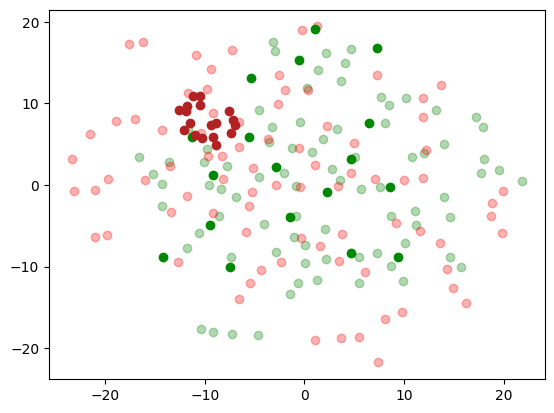

In [42]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

xgp = [x for x,y in genuine_pros_vis_dims]
ygp = [y for x,y in genuine_pros_vis_dims]
xgc = [x for x,y in genuine_cons_vis_dims]
ygc = [y for x,y in genuine_cons_vis_dims]

xhp = [x for x,y in hr_pros_vis_dims]
yhp = [y for x,y in hr_pros_vis_dims]
xhc = [x for x,y in hr_cons_vis_dims]
yhc = [y for x,y in hr_cons_vis_dims]

plt.scatter(xgp, ygp, c='green', alpha=0.3)
plt.scatter(xgc, ygc, c='red', alpha=0.3)
plt.scatter(xhp, yhp, c='#008800')
plt.scatter(xhc, yhc, c='#b22222')